In [87]:
import pandas as pd

df01 = pd.read_csv(r'data/990001.csv',sep=';', names=['Num','X','Y','Dist'])
df01

,Num,X,Y,Dist
0,6a,132.0273,105.5994,48.286822
1,6,106.5573,104.7235,72.991942
2,7,140.6679,108.2610,39.255562
3,8,167.3911,121.9081,10.148766
4,7a,152.7813,117.7490,25.075741
5,7b,155.1098,112.1205,24.402639
6,9001,100.0000,100.0000,0.000000


In [12]:
df02 = pd.read_csv(r'data/990002.csv',sep=';', names=['Num','X','Y','Dist'])
df02

,Num,X,Y,Dist
0,6a,147.0338,84.9535,32.513093
1,6,124.3194,73.3954,8.081438
2,7,153.7402,91.0169,41.498460
3,8,172.1918,114.6797,70.862721
4,7a,160.7087,104.7360,55.685659
5,7b,165.1976,100.6186,56.426914
6,9002,181.4615,118.8113,0.000000


Дополнительный шаг - выборка номер одинаковых номеров пунктов.
Сортирую номера и записи в таблицы, надеюсь, что принцип сортировки и в сете и в дф одинаковые, но лучше будет убедиться.

In [104]:
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')

In [ ]:
Создаю по два набора точек - mp01,mp02 - все точки, включая стоянки. mp01_c, mp02_c - набор общих точек.

In [116]:
from shapely.geometry import MultiPoint

mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])

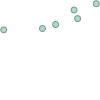

In [117]:
mp01_c

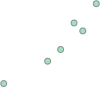

In [118]:
mp02_c

In [119]:
from shapely import affinity
from scipy.optimize import minimize

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    n_geom = mov(*x0,geom2)
    return calc_dist(geom1,n_geom)

x0 = (0,0,0)

re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')

In [120]:
re

     fun: 0.0019267370659772987
     jac: array([ 0.5593133 ,  0.16264231,  0.27411119,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 213
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([-37.13354239,  90.74529647, -25.00025258])

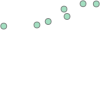

In [77]:
mp_moved = mov(-37.1335426 ,  90.74529586, -25.00025255,mp02)
mp_moved

Считаем расстояния от стоянки 99002 до всех точек.  
До сдвижки, после сдвижки, значение сдвижки.

In [123]:
dist_do = [mp02[-1].distance(i) for i in mp02]
dist_po = [mp_moved[-1].distance(i) for i in mp_moved]
od = zip(dist_do,dist_po)
od = [[i[0],i[1],i[0]-i[1]] for i in od]
df_od = pd.DataFrame.from_records(od,columns=('Before','After','Diff'))
df_od

,Before,After,Diff
0,48.286822,48.286822,2.842171e-14
1,72.991942,72.991942,0.000000e+00
2,39.255562,39.255562,2.842171e-14
3,10.148766,10.148766,8.881784e-15
4,25.075741,25.075741,3.552714e-14
5,24.402639,24.402639,3.552714e-14
6,0.000000,0.000000,0.000000e+00


Таблица с координатам сдвинутого 99002:

In [133]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved.geoms))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df



,Num,X,Y,Dist
0,6a,132.027301,105.599400,48.286822
1,6,106.556396,104.723836,72.991942
2,7,140.667879,108.260421,39.255562
3,8,167.391099,121.908100,10.148766
4,7a,152.781469,117.749080,25.075741
5,7b,155.109681,112.120347,24.402639
6,9002,177.538390,121.735012,0.000000


Координаты 99001:

In [134]:
df01

,Num,X,Y,Dist
0,6a,132.0273,105.5994,48.286822
1,6,106.5573,104.7235,72.991942
2,7,140.6679,108.2610,39.255562
3,8,167.3911,121.9081,10.148766
4,7a,152.7813,117.7490,25.075741
5,7b,155.1098,112.1205,24.402639
6,9001,100.0000,100.0000,0.000000


Оригинальные координаты 990001:

In [135]:
df02

,Num,X,Y,Dist
0,6a,147.0338,84.9535,32.513093
1,6,124.3194,73.3954,8.081438
2,7,153.7402,91.0169,41.498460
3,8,172.1918,114.6797,70.862721
4,7a,160.7087,104.7360,55.685659
5,7b,165.1976,100.6186,56.426914
6,9002,181.4615,118.8113,0.000000
